In [1]:
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
from scipy.stats import chi2_contingency, ttest_ind
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import shap

In [2]:
# Load and inspect data
df = pd.read_csv("adult23.csv")

# Keep only selected columns for heart disease modeling
cols = [
    'MIEV_A', 'CHDEV_A', 'ANGEV_A', 'STREV_A', 'HYPEV_A', 'CHLEV_A',
    'DIBLAST1_A', 'BMICAT_A', 'SMKCIGST_A', 'ASEV_A', 'CANEV_A', 'ARTHEV_A',
    'COPDEV_A', 'DEPEV_A', 'ANXEV_A', 'DEPFREQ_A', 'ANXFREQ_A', 'ANXMED_A',
    'NOTCOV_A', 'PLN1PAY4_A', 'PLN1PAY5_A', 'PLN1PAY6_A', 'PRDEDUC1_A',
    'AGEP_A', 'SEX_A', 'RACEALLP_A', 'EDUCP_A', 'EMPLASTWK_A', 'REGION',
    'URBRRL'
]
df_filtered = df[cols]

In [3]:
# Drop rows with more than 50% missing values
thresh = len(df_filtered) * 0.5
df_filtered = df_filtered.dropna(axis=1, thresh=thresh)

In [4]:
# Handle survey data codes
ambiguous_codes = [7, 8, 9]
binary_map_cols = [
    'MIEV_A', 'CHDEV_A', 'ANGEV_A', 'STREV_A', 'HYPEV_A', 'CHLEV_A',
    'ASEV_A', 'CANEV_A', 'ARTHEV_A', 'COPDEV_A', 'DEPEV_A', 'ANXEV_A',
    'ANXMED_A', 'PLN1PAY4_A', 'PLN1PAY5_A', 'PLN1PAY6_A'
]

for col in binary_map_cols:
    df_filtered[col] = df_filtered[col].replace(ambiguous_codes, pd.NA)
    df_filtered[col] = df_filtered[col].map({1: 1, 2: 0})


ordinal_or_multiclass = [
    'DIBLAST1_A',   # diabetes
    'BMICAT_A',     # BMI
    'SMKCIGST_A',   # smoking status
    'DEPFREQ_A',    # depression frequency
    'ANXFREQ_A',    # anxiety frequency
    'NOTCOV_A',     # insurance coverage
    'PRDEDUC1_A',   # deductible
    'SEX_A',        # male or female
    'RACEALLP_A',   # race
    'EDUCP_A',      # education 
    'EMPLASTWK_A',  # employment
    'REGION',       # region
    'URBRRL'        # urban/rural
]

for col in ordinal_or_multiclass:
    df_filtered[col] = df_filtered[col].replace(ambiguous_codes, pd.NA)
    
for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])

In [5]:
# Build binary heart_disease target variable
df_filtered['heart_disease'] = (
    (df_filtered['CHDEV_A'] == 1) |
    (df_filtered['ANGEV_A'] == 1) |
    (df_filtered['MIEV_A']  == 1)
).astype(int)

In [6]:
# Chi-square and T-tests
df_stats = df_filtered.copy()

cat_feats = [
    'MIEV_A', 'CHDEV_A', 'ANGEV_A', 'STREV_A', 'HYPEV_A', 'CHLEV_A',
    'DIBLAST1_A', 'BMICAT_A', 'SMKCIGST_A', 'ASEV_A', 'CANEV_A', 'ARTHEV_A',
    'COPDEV_A', 'DEPEV_A', 'ANXEV_A', 'DEPFREQ_A', 'ANXFREQ_A', 'ANXMED_A',
    'NOTCOV_A', 'PLN1PAY4_A', 'PLN1PAY5_A', 'PLN1PAY6_A',
    'SEX_A', 'RACEALLP_A', 'EDUCP_A', 'EMPLASTWK_A', 'REGION', 'URBRRL'
]

num_feats = ['PRDEDUC1_A', 'AGEP_A']  

df_stats = df_stats.dropna(subset=['heart_disease'])

chi2_results = []
for col in cat_feats:
    tbl = pd.crosstab(df_stats[col].fillna("Missing"), df_stats['heart_disease'])
    if tbl.shape[0] > 1: 
        chi2, p, dof, expected = chi2_contingency(tbl)
        chi2_results.append({
            'feature': col,
            'chi2_stat': chi2,
            'p_value': p
        })

chi2_df = pd.DataFrame(chi2_results).sort_values('p_value')

ttest_results = []
for col in num_feats:
    grp0 = df_stats[df_stats['heart_disease'] == 0][col].dropna()
    grp1 = df_stats[df_stats['heart_disease'] == 1][col].dropna()
    if len(grp0) > 1 and len(grp1) > 1:
        t_stat, p = ttest_ind(grp0, grp1, equal_var=False)
        ttest_results.append({
            'feature': col,
            't_stat': t_stat,
            'p_value': p
        })

t_df = pd.DataFrame(ttest_results).sort_values('p_value')

print("Chi-Square Test: Categorical Features")
print(chi2_df.to_string(index=False))

print("\nT-Test: Numerical Features")
print(t_df.to_string(index=False))

Chi-Square Test: Categorical Features
    feature    chi2_stat       p_value
     MIEV_A 12781.472403  0.000000e+00
    CHDEV_A 21933.256244  0.000000e+00
    ANGEV_A  6479.342173  0.000000e+00
    HYPEV_A  1700.647180  0.000000e+00
    CHLEV_A  1444.059028  0.000000e+00
EMPLASTWK_A  1112.667506 5.830274e-244
   ARTHEV_A  1055.036214 1.957459e-231
   COPDEV_A   904.369983 1.101137e-198
    STREV_A   763.131015 5.601172e-168
    CANEV_A   499.531271 1.202144e-110
 SMKCIGST_A   358.715492  2.301735e-76
 DIBLAST1_A   362.510841  3.177716e-75
    EDUCP_A   142.744727  6.370807e-27
  DEPFREQ_A   127.106779  1.618202e-26
      SEX_A   101.406690  7.491034e-24
   NOTCOV_A    92.442908  6.929527e-22
     URBRRL    92.232085  7.262276e-20
 RACEALLP_A    82.768024  2.210085e-16
   BMICAT_A    58.952747  9.839059e-13
    DEPEV_A    49.069362  2.470693e-12
  ANXFREQ_A    57.230184  1.106972e-11
 PLN1PAY4_A    41.704993  1.061376e-10
     REGION    44.347145  1.273486e-09
   ANXMED_A    24.549946  

In [7]:
top_chi2_features = chi2_df.loc[chi2_df['p_value'] < 0.05, 'feature'].tolist()

for col in ['CHDEV_A', 'MIEV_A', 'ANGEV_A']:
    if col in top_chi2_features:
        top_chi2_features.remove(col)

In [8]:
X = df_filtered[top_chi2_features + ['AGEP_A', 'PRDEDUC1_A']]
y = df_filtered['heart_disease']

In [9]:
# One-hot encoding
categorical_cols = [
    col for col in X.columns
    if X[col].nunique() > 2 and X[col].dtype in ['int64', 'float64']
]

column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_encoded = column_transformer.fit_transform(X)

encoded_col_names = column_transformer.named_transformers_['onehot'].get_feature_names(categorical_cols)

passthrough_cols = [col for col in X.columns if col not in categorical_cols]
final_cols = list(encoded_col_names) + passthrough_cols

X_final = pd.DataFrame(X_encoded, columns=final_cols)

print(X_final.shape)

(29522, 136)


In [10]:
# Data leakage check
leak_check = [col for col in X_final.columns if 'CHDEV' in col or 'MIEV' in col or 'ANGEV' in col]
print("Potential leakage columns in X_final:", leak_check)

Potential leakage columns in X_final: []


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (23617, 136)
Test shape : (5905, 136)


In [12]:
# Logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5422
           1       0.48      0.07      0.13       483

    accuracy                           0.92      5905
   macro avg       0.70      0.53      0.54      5905
weighted avg       0.89      0.92      0.89      5905



In [13]:
# Optimize logisitic regression model using hyperparameter tuning via GridSearch
lr = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced'] 
}

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',    
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_lr_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


In [14]:
# Log reg model after hyperparameter tuning
y_pred = best_lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      5422
           1       0.21      0.76      0.33       483

    accuracy                           0.74      5905
   macro avg       0.59      0.75      0.58      5905
weighted avg       0.91      0.74      0.80      5905



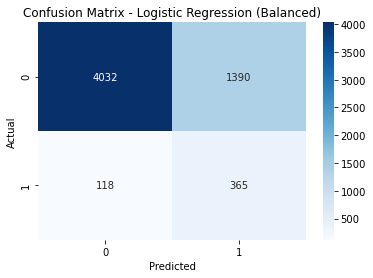

In [15]:
# Log reg confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Balanced)")
plt.show()

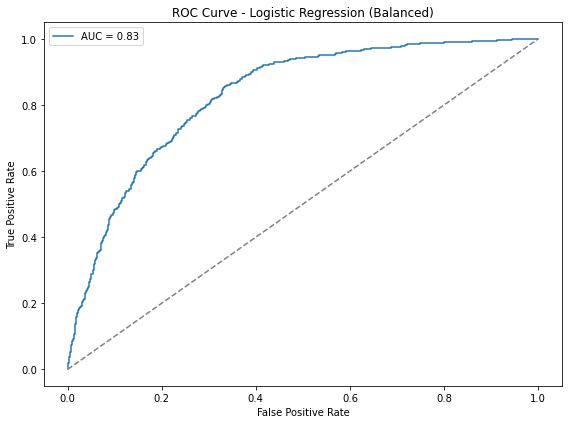

In [16]:
# ROC curve
y_proba = best_lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Balanced)')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Random forest model
rf_model = RandomForestClassifier(
    n_estimators=100,        
    class_weight='balanced', 
    random_state=42,          
    n_jobs=-1                
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5422
           1       0.31      0.02      0.03       483

    accuracy                           0.92      5905
   macro avg       0.61      0.51      0.49      5905
weighted avg       0.87      0.92      0.88      5905



In [18]:
# Optimize random forest model using hyperparameter tuning via GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=2
)

grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_
print("Best RF parameters:", grid_rf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; tota

In [19]:
# Random forest model after hyperparameter tuning
y_pred_best_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      5422
           1       0.26      0.47      0.33       483

    accuracy                           0.85      5905
   macro avg       0.60      0.68      0.62      5905
weighted avg       0.89      0.85      0.87      5905



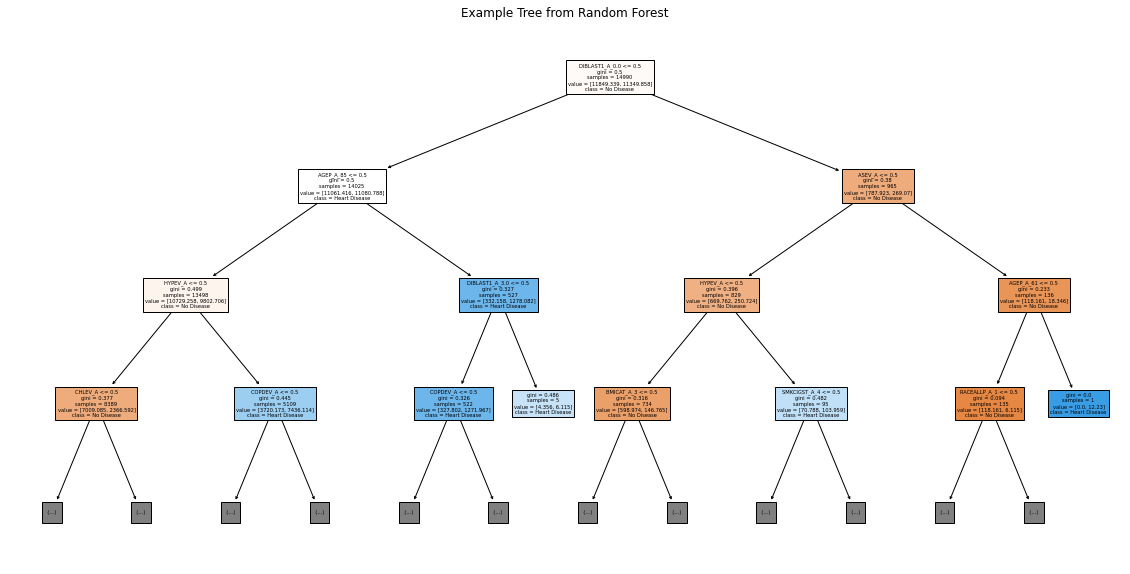

In [20]:
# Visualization
plt.figure(figsize=(20, 10))
plot_tree(best_rf_model.estimators_[0], 
          feature_names=X_final.columns,
          class_names=["No Disease", "Heart Disease"],
          max_depth=3, 
          filled=True)
plt.title("Example Tree from Random Forest")
plt.show()

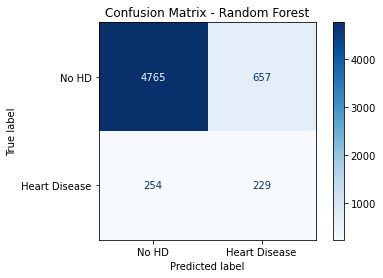

In [21]:
# Random forest confusion matrix
y_pred_rf = best_rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HD", "Heart Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

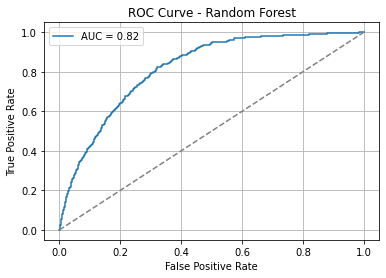

In [22]:
# ROC curve
y_probs_rf = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
auc = roc_auc_score(y_test, y_probs_rf)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

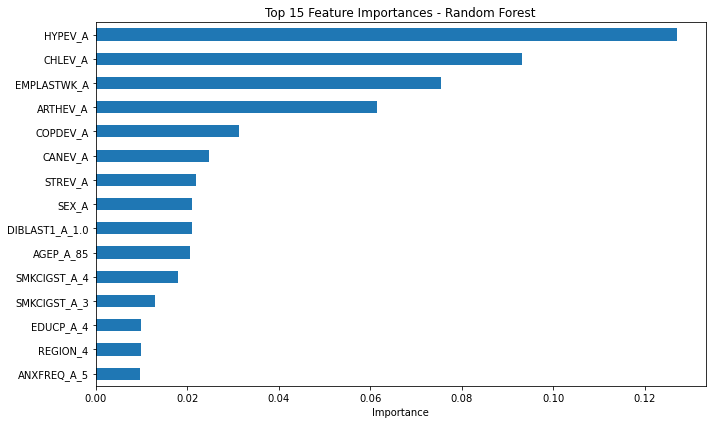

In [23]:
# Top 15 important features in random forest prediction
importances = best_rf_model.feature_importances_
feat_imp = pd.Series(importances, index=X_final.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [24]:
# Gradient boosting model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    scale_pos_weight= (len(y_train) - sum(y_train)) / sum(y_train), 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, ...)

In [25]:
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.73      0.84      5422
           1       0.20      0.75      0.32       483

    accuracy                           0.73      5905
   macro avg       0.58      0.74      0.58      5905
weighted avg       0.91      0.73      0.79      5905



In [26]:
# Optimize gradient boosting model using hyperparameter tuning via GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'scale_pos_weight': [1, (len(y_train) - sum(y_train)) / sum(y_train)]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)
best_xgb_model = grid_xgb.best_estimator_
print("Best XGBoost Params:", grid_xgb.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 11.23045054375971}


In [27]:
# Gradient boosting model after hyperparameter tuning
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.75      0.84      5422
           1       0.21      0.74      0.32       483

    accuracy                           0.75      5905
   macro avg       0.59      0.74      0.58      5905
weighted avg       0.91      0.75      0.80      5905



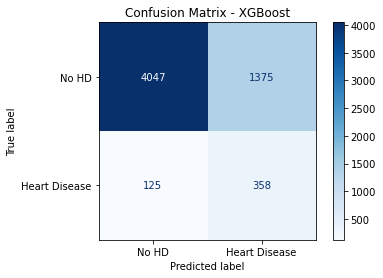

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HD", "Heart Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()

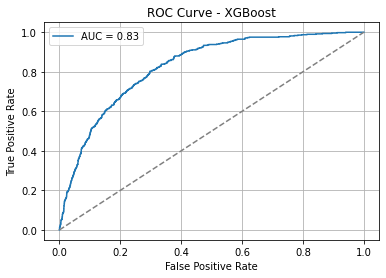

In [29]:
# ROC curve
y_probs_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb)
auc_score = roc_auc_score(y_test, y_probs_xgb)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# CatBoost model
cat_cols = [col for col in X.columns if X[col].nunique() < 10]
cat_features = [X.columns.get_loc(col) for col in cat_cols]

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_cb[cat_cols] = X_train_cb[cat_cols].astype(str)
X_test_cb[cat_cols] = X_test_cb[cat_cols].astype(str)

model_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, (len(y_train_cb) - sum(y_train_cb)) / sum(y_train_cb)],
    random_seed=42,
    verbose=100
)

model_cb.fit(
    X_train_cb,
    y_train_cb,
    cat_features=cat_features,
    eval_set=(X_test_cb, y_test_cb),
    early_stopping_rounds=50
)

0:	learn: 0.7710926	test: 0.7471761	best: 0.7471761 (0)	total: 68.8ms	remaining: 34.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7711253513
bestIteration = 27

Shrink model to first 28 iterations.


In [31]:
y_pred_cb = model_cb.predict(X_test_cb)
print(classification_report(y_test_cb, y_pred_cb))

              precision    recall  f1-score   support

           0       0.98      0.70      0.81      5422
           1       0.19      0.82      0.31       483

    accuracy                           0.71      5905
   macro avg       0.59      0.76      0.56      5905
weighted avg       0.91      0.71      0.77      5905



In [32]:
# Optimize CatBoost model using hyperparameter tuning via GridSearch
param_grid_cb = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500],
    'l2_leaf_reg': [1, 3, 5],
}

cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, (len(y_train_cb) - sum(y_train_cb)) / sum(y_train_cb)],
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

grid_cb = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cb,
    cv=3,
    scoring='f1',
    verbose=2
)

grid_cb.fit(X_train_cb, y_train_cb)

best_cb_model = grid_cb.best_estimator_
print("Best CatBoost Parameters:", grid_cb.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   1.8s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   1.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rat

In [33]:
# CatBoost model after hyperparameter tuning
y_pred_cb = best_cb_model.predict(X_test_cb)
print(classification_report(y_test_cb, y_pred_cb))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5422
           1       0.23      0.65      0.34       483

    accuracy                           0.79      5905
   macro avg       0.60      0.73      0.61      5905
weighted avg       0.90      0.79      0.83      5905



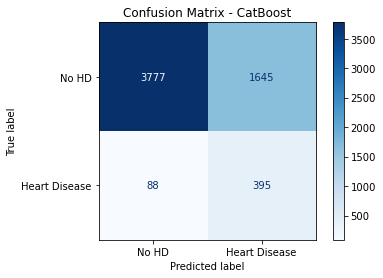

In [34]:
# Confusion matrix
y_pred_cb = model_cb.predict(X_test_cb)
cm = confusion_matrix(y_test_cb, y_pred_cb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HD", "Heart Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.grid(False)
plt.show()

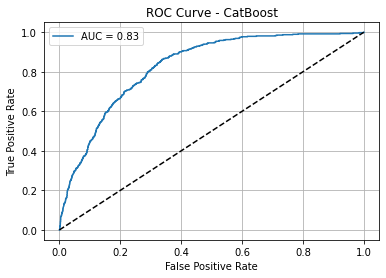

In [35]:
# ROC curve
y_probs_cb = model_cb.predict_proba(X_test_cb)[:, 1]
fpr, tpr, _ = roc_curve(y_test_cb, y_probs_cb)
auc = roc_auc_score(y_test_cb, y_probs_cb)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost")
plt.legend()
plt.grid(True)
plt.show()

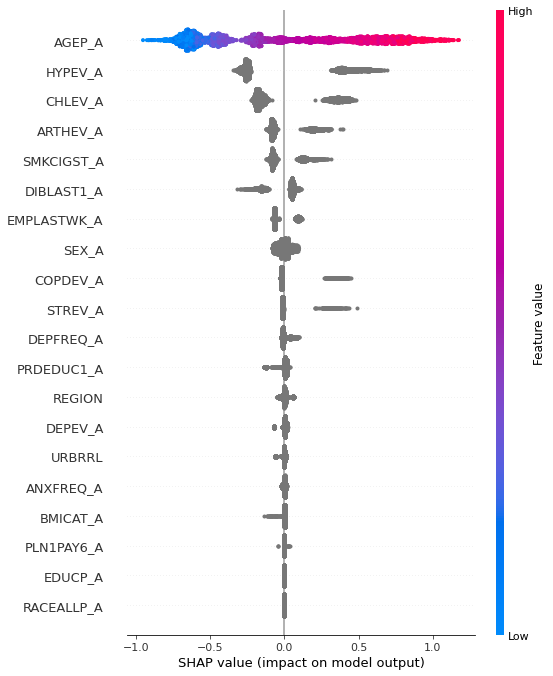

In [37]:
# SHAP plot
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_test_cb)

shap.summary_plot(shap_values, X_test_cb)

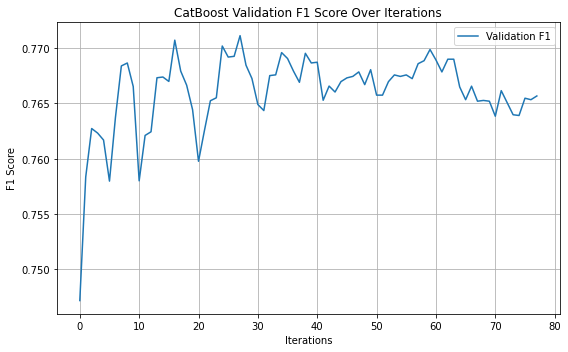

In [38]:
# Evaluation metrics over time
eval_results = model_cb.get_evals_result()

plt.figure(figsize=(8, 5))
plt.plot(eval_results['validation']['F1'], label='Validation F1')
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.title("CatBoost Validation F1 Score Over Iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()